In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("./mushroomDataSet/Mushrooms"))

# Any results you write to the current directory are saved as output.

['Hygrocybe', 'Boletus', 'Amanita', 'Cortinarius', 'Entoloma', 'Agaricus', 'Suillus', 'Lactarius', 'Russula']


In [2]:
import matplotlib.pyplot as plt
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
NUM_CLASSES = 9

CHANNELS = 3

IMAGE_RESIZE = 224
RESNET50_POOLING_AVERAGE = 'avg'
DENSE_LAYER_ACTIVATION = 'softmax'
OBJECTIVE_FUNCTION = 'categorical_crossentropy'

# Common accuracy metric for all outputs, but can use different metrics for different output
LOSS_METRICS = ['accuracy']

# EARLY_STOP_PATIENCE must be < NUM_EPOCHS
NUM_EPOCHS = 50
EARLY_STOP_PATIENCE = 10

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# Training images processed in each step would be no.-of-train-images / STEPS_PER_EPOCH_TRAINING
STEPS_PER_EPOCH_TRAINING = 16
STEPS_PER_EPOCH_VALIDATION = 16

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# NOTE that these BATCH* are for Keras ImageDataGenerator batching to fill epoch step input
BATCH_SIZE_TRAINING = 100
BATCH_SIZE_VALIDATION = 50

# Using 1 to easily manage mapping between test_generator & prediction for submission preparation
BATCH_SIZE_TESTING = 1

In [4]:
from tensorflow.python.keras.applications import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, BatchNormalization, Dropout

In [5]:
resnet_weights_path = './resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [6]:
model = Sequential()

# 1st layer as the lumpsum weights from resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
# NOTE that this layer will be set below as NOT TRAINABLE, i.e., use it as is
model.add(gl(include_top = False, pooling = RESNET50_POOLING_AVERAGE, weights = resnet_weights_path))

model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(NUM_CLASSES, activation = DENSE_LAYER_ACTIVATION))

# Say not to train first layer (ResNet) model as it is already trained
model.layers[0].trainable = False

Instructions for updating:
Colocations handled automatically by placer.


In [7]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
batch_normalization_v1 (Batc (None, 2048)              8192      
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
batch_normalization_v1_2 (Ba (None, 128)               512       
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 1161      
Total para

In [8]:
from tensorflow.python.keras import optimizers

sgd = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
model.compile(optimizer = sgd, loss = OBJECTIVE_FUNCTION, metrics = LOSS_METRICS)

In [9]:
# Early stopping & checkpointing the best model in ../working dir & restoring that as our model for prediction
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, mode='auto')
cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = EARLY_STOP_PATIENCE)
cb_checkpointer = ModelCheckpoint(filepath = './best.hdf5', monitor = 'val_loss', save_best_only = True, mode = 'auto')

In [10]:
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

image_size = IMAGE_RESIZE

# preprocessing_function is applied on each image but only after re-sizing & augmentation (resize => augment => pre-process)
# Each of the keras.application.resnet* preprocess_input MOSTLY mean BATCH NORMALIZATION (applied on each batch) stabilize the inputs to nonlinear activation functions
# Batch Normalization helps in faster convergence
#data_generator = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)
data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
# flow_From_directory generates batches of augmented data (where augmentation can be color conversion, etc)
# Both train & valid folders must have NUM_CLASSES sub-folders
train_generator = data_generator.flow_from_directory(
        './mush-now/train',
        target_size=(image_size, image_size),
        batch_size=BATCH_SIZE_TRAINING,
        class_mode='categorical')
        

validation_generator = data_generator.flow_from_directory(
    './mush-now/val',
    target_size=(image_size, image_size),
    batch_size=BATCH_SIZE_VALIDATION,
    class_mode='categorical') 
test_generator = data_generator.flow_from_directory(
    './mush-now/test',
    target_size=(image_size, image_size),
    batch_size=BATCH_SIZE_VALIDATION,
    class_mode='categorical') 


Using TensorFlow backend.


Found 4031 images belonging to 9 classes.
Found 1344 images belonging to 9 classes.
Found 1339 images belonging to 9 classes.


In [11]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


In [12]:
fit_history = model.fit_generator(
        train_generator,
        steps_per_epoch=STEPS_PER_EPOCH_TRAINING,
        epochs = 20,
        validation_data = validation_generator, 
        callbacks=[cb_checkpointer,cb_early_stopper,reduce_lr]
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
41/41 [==============================] - 142s 3s/step - loss: 1.3624 - acc: 0.5654 - val_loss: 1.3726 - val_acc: 0.5365
Epoch 2/20
41/41 [==============================] - 79s 2s/step - loss: 0.4671 - acc: 0.8636 - val_loss: 0.9832 - val_acc: 0.6704
Epoch 3/20
41/41 [==============================] - 79s 2s/step - loss: 0.2249 - acc: 0.9558 - val_loss: 0.9024 - val_acc: 0.6942
Epoch 4/20
41/41 [==============================] - 79s 2s/step - loss: 0.1131 - acc: 0.9834 - val_loss: 0.8763 - val_acc: 0.7210
Epoch 5/20
41/41 [==============================] - 79s 2s/step - loss: 0.0658 - acc: 0.9938 - val_loss: 0.8535 - val_acc: 0.7188
Epoch 6/20
41/41 [==============================] - 80s 2s/step - loss: 0.0460 - acc: 0.9960 - val_loss: 0.8843 - val_acc: 0.7188
Epoch 7/20
41/41 [==============================] - 79s 2s/step - loss: 0.0312 - acc: 0.9973 - val_loss: 0.9221 - val_acc: 0.7217
Epoch 8/20
41/41 [=======================

In [ ]:
tes_history = model.evaluate_generator(
        test_generator,
    verbose=1,
)

18/27 [===================>..........] - ETA: 8s - loss: 0.9737 - acc: 0.7211

In [13]:
model.load_weights("./best.hdf5")

In [14]:
print(fit_history.history.keys())

dict_keys(['val_loss', 'loss', 'lr', 'val_acc', 'acc'])


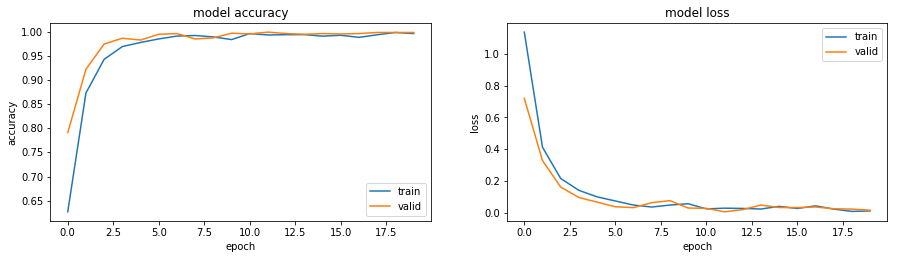

In [15]:
plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(fit_history.history['acc'])  
plt.plot(fit_history.history['val_acc'])
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(fit_history.history['loss'])  
plt.plot(fit_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()

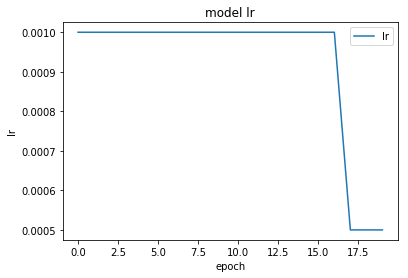

In [16]:
plt.plot(fit_history.history['lr'])  
plt.title('model lr')  
plt.ylabel('lr')  
plt.xlabel('epoch')  
plt.legend(['lr']) 
plt.show()

In [17]:
model.load_weights('./best.hdf5')

In [18]:
model.save('./best_model.h5',include_optimizer=True)